In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from pathlib import Path
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os

In [21]:
# Define your dataset class
class NpyDataset(Dataset):
    def __init__(self, npy_files_folder):
        # Convert the string path to a Path object
        npy_files_folder_path = Path(npy_files_folder)
        # Load all .npy files in the folder
        self.data = [np.load(file) for file in npy_files_folder_path.glob("*.npy")]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32)

In [22]:
# Load data
data_folder = "map_arrays"
dataset = NpyDataset(data_folder)

In [23]:
data_size = len(dataset)
data_size ## should be 128

128

In [25]:
# Split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

In [26]:
train_data[0].shape ## should be torch.Size([11, 16, 42])

torch.Size([11, 16, 42])

In [27]:
train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [29]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2_mean = nn.Linear(512, latent_dim)  # Mean of the latent space
        self.fc2_logvar = nn.Linear(512, latent_dim)  # Log variance of the latent space

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 512)
        self.fc4 = nn.Linear(512, input_dim)

    def encode(self, x):
        x = F.relu(self.fc1(x))
        mean = self.fc2_mean(x)
        logvar = self.fc2_logvar(x)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        z = F.relu(self.fc3(z))
        reconstruction = torch.sigmoid(self.fc4(z))
        return reconstruction

    def forward(self, x):
        # Flatten the input tensor
        x_flat = x.view(-1, self.input_dim)
        
        mean, logvar = self.encode(x_flat)
        z = self.reparameterize(mean, logvar)
        reconstruction_flat = self.decode(z)
        
        # Reshape the reconstructed flat tensor back to its original shape
        reconstruction = reconstruction_flat.view(-1, 11, 16, 42)
        
        return reconstruction, mean, logvar

In [30]:
# Instantiate the VAE model
input_dim = 16 * 11 * 42
latent_dim = 64  # Latent dimension
model = VAE(input_dim, latent_dim).to(device)

In [31]:
def vae_loss_function(reconstruction, x, mu, logvar):
    # Reshape the target tensor to match the shape of the reconstruction
    x = x.view(-1, 11, 16, 42)
    
    # Compute reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(reconstruction, x, reduction='sum')

    # Compute KL divergence
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss
    total_loss = reconstruction_loss + kl_divergence
    return total_loss

In [32]:
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_loss = float('inf')  # Initialize best loss to positive infinity
best_epoch = 0  # Initialize the epoch at which the best loss occurred

num_epochs = 300
patience = 50
# Training Loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, batch in enumerate(train_dataloader):
        # Move batch to GPU
        batch = batch.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs, mu, logvar = model(batch)
        
        # Compute the loss
        loss = vae_loss_function(outputs, batch, mu, logvar)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Calculate average training loss for the epoch
    epoch_loss = running_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss}")
    
    # Evaluate Model
    # Calculate reconstruction loss on the test set
    test_loss = 0.0
    with torch.no_grad():
        for batch in test_dataloader:
            # Move batch to GPU
            batch = batch.to(device)
            
            outputs, mu, logvar = model(batch)
            test_loss += vae_loss_function(outputs, batch, mu, logvar).item()

    average_test_loss = test_loss / len(test_dataloader)
    print(f"Average Test Loss: {average_test_loss}")

    # Check if the current test loss is the best so far
    if average_test_loss < best_loss:
        best_loss = average_test_loss
        best_epoch = epoch
        # Save the best model
        torch.save(model.state_dict(), 'best_vae_model.pth')

    # Check for early stopping criterion
    if epoch - best_epoch >= patience:
        print(f"No improvement in test loss for {patience} epochs. Early stopping.")
        break



Epoch [1/300], Training Loss: 959.8176610610064
Average Test Loss: 416.73810518704926
Epoch [2/300], Training Loss: 379.7207581763174
Average Test Loss: 341.1811224130484
Epoch [3/300], Training Loss: 310.85154754040286
Average Test Loss: 317.106196476863
Epoch [4/300], Training Loss: 278.2953561521044
Average Test Loss: 324.2701474703275
Epoch [5/300], Training Loss: 260.23298256070007
Average Test Loss: 326.10719416691705
Epoch [6/300], Training Loss: 250.5365192188936
Average Test Loss: 303.92274709848255
Epoch [7/300], Training Loss: 233.7424087524414
Average Test Loss: 297.9014446551983
Epoch [8/300], Training Loss: 216.2284984214633
Average Test Loss: 292.9341236994817
Epoch [9/300], Training Loss: 202.9164255179611
Average Test Loss: 279.9607766958383
Epoch [10/300], Training Loss: 196.58847180534812
Average Test Loss: 276.36165032019983
Epoch [11/300], Training Loss: 192.25076712814032
Average Test Loss: 267.6022286048302
Epoch [12/300], Training Loss: 181.3030678244198
Average

In [17]:
tile_set_path = 'gray_tile'
tile_size = 16
tile_set = []
for filename in os.listdir(tile_set_path):
    tile = np.load(os.path.join(tile_set_path, filename))
    tile_set.append(tile)

In [33]:
def convert_embedding_to_image(embedding, tile_set, tile_size):
    num_tiles_h, num_tiles_w, _ = embedding.shape
    # Initialize the image with the appropriate dimensions
    reconstructed_image = np.zeros((num_tiles_h * tile_size, num_tiles_w * tile_size), dtype=tile_set[0].dtype)
    
    # Loop through each position in the embedding array
    for i in range(num_tiles_h):
        for j in range(num_tiles_w):
            # Find the index of the tile (one-hot encoding)
            tile_index = np.argmax(embedding[i, j])
            # Retrieve the tile from the tile set
            tile = tile_set[tile_index]
            # Place the tile in the correct position in the reconstructed image
            reconstructed_image[i*tile_size:(i+1)*tile_size, j*tile_size:(j+1)*tile_size] = tile

    return reconstructed_image

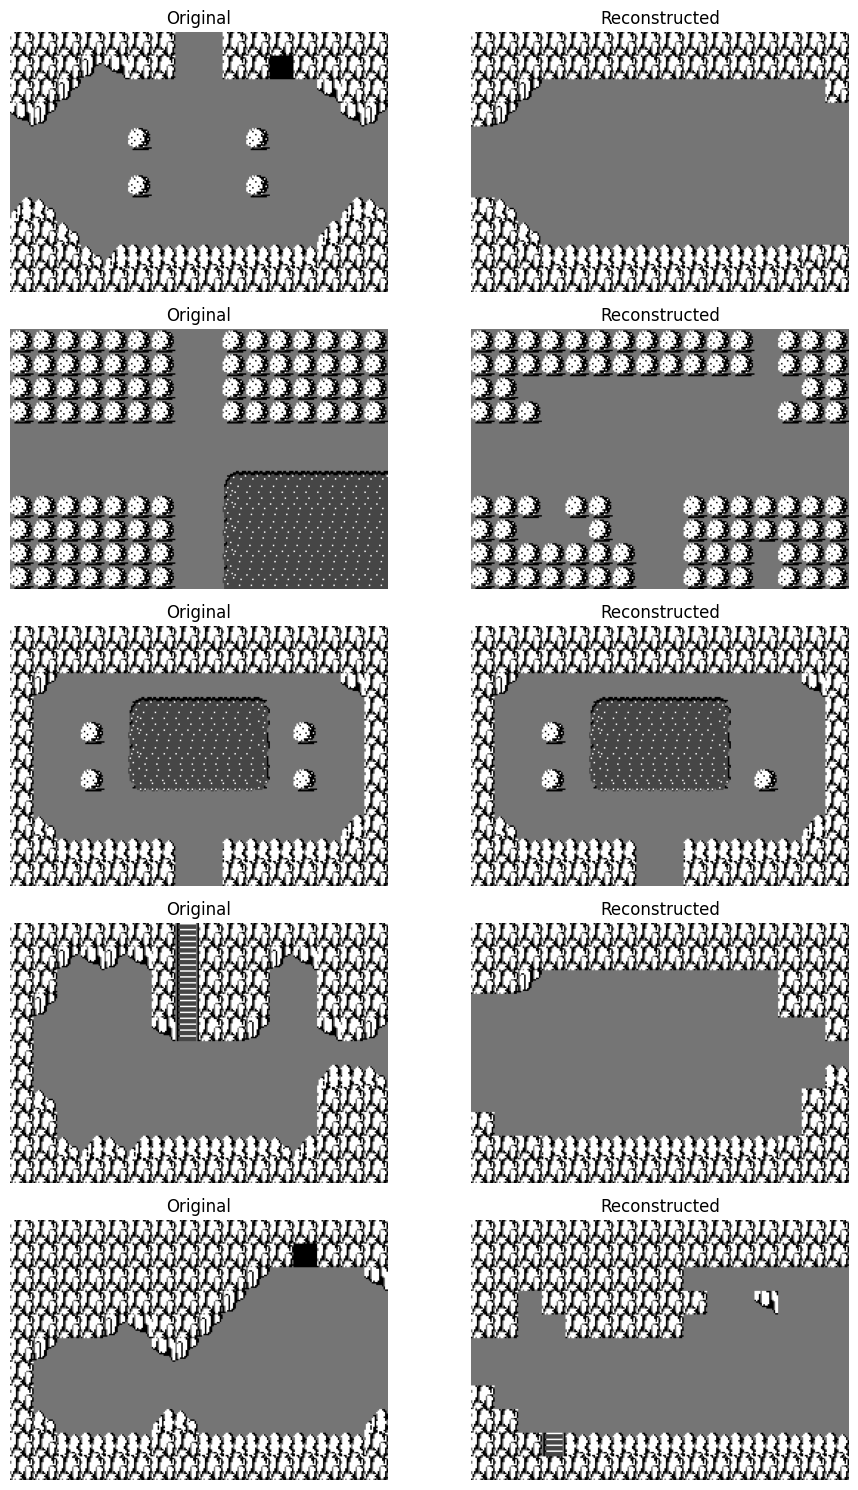

In [34]:
# Define a function to plot original and reconstructed images
def plot_images(original, reconstructed):
    num_images = min(original.size(0), 5)  # Plot up to 5 images
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 3*num_images))
    
    for i in range(num_images):
        # Plot original image
        img1 = convert_embedding_to_image(original[i].numpy(), tile_set, tile_size)
        axes[i, 0].imshow(img1.squeeze(), cmap='gray')
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')
        
        img2 = convert_embedding_to_image(reconstructed[i].numpy(), tile_set, tile_size)
        axes[i, 1].imshow(img2.squeeze(), cmap='gray')
        axes[i, 1].set_title('Reconstructed')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Load the best VAE model
best_vae_model = VAE(input_dim, latent_dim).to(device)
best_vae_model.load_state_dict(torch.load('best_vae_model.pth'))

# Pass some test images through the VAE model to get reconstructed images
original_images = []
reconstructed_images = []

# Set the best VAE model to evaluation mode
best_vae_model.eval()

# Pass test batches through the best VAE model
with torch.no_grad():
    for batch in test_dataloader:
        # Move batch to GPU and convert to torch.float32
        batch = batch.to(torch.float32).to(device)
        
        # Forward pass using the best VAE model
        outputs, _, _ = best_vae_model(batch)
        
        # Append original and reconstructed images to lists
        original_images.append(batch.cpu())  # Move back to CPU for visualization
        reconstructed_images.append(outputs.cpu())  # Move back to CPU for visualization

# Concatenate lists of tensors into single tensors
original_images = torch.cat(original_images, dim=0)
reconstructed_images = torch.cat(reconstructed_images, dim=0)

# Plot the original and reconstructed images
plot_images(original_images, reconstructed_images)


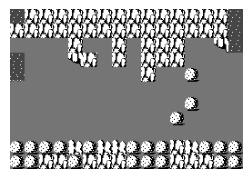

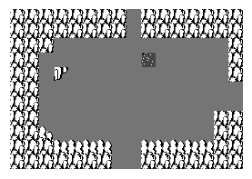

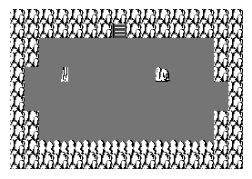

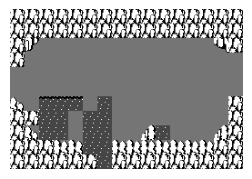

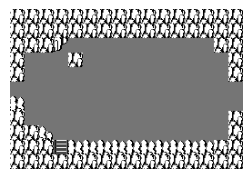

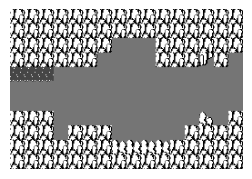

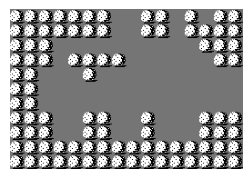

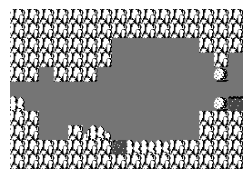

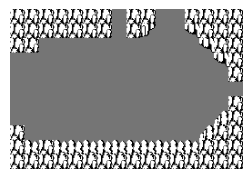

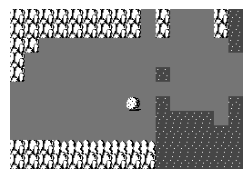

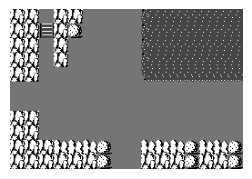

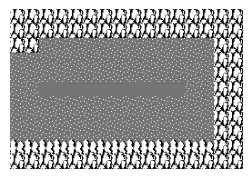

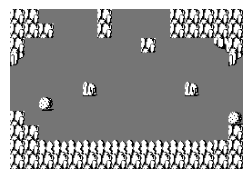

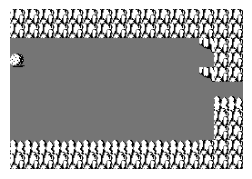

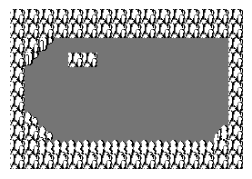

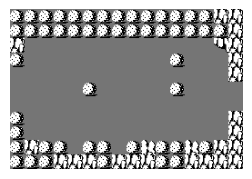

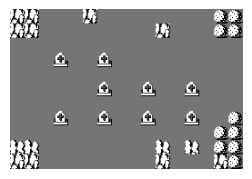

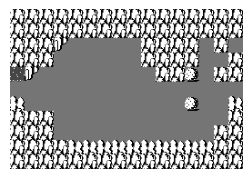

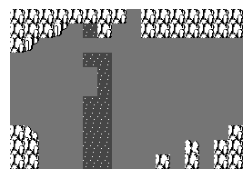

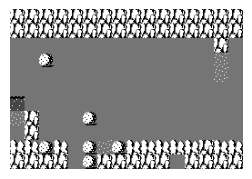

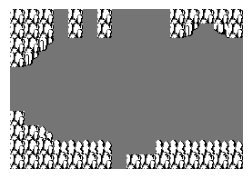

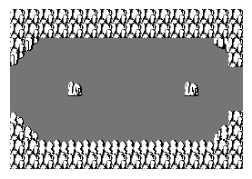

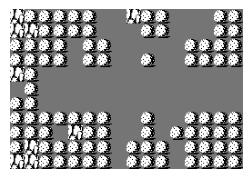

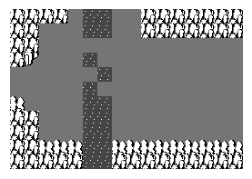

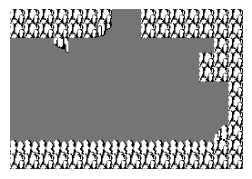

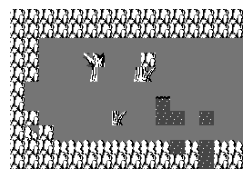

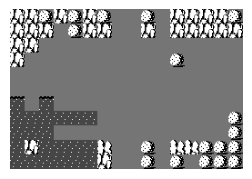

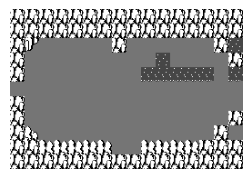

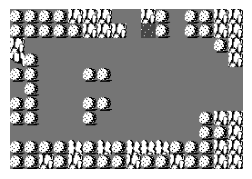

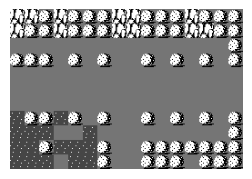

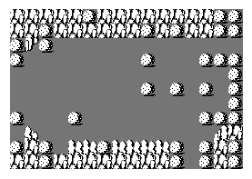

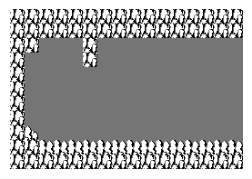

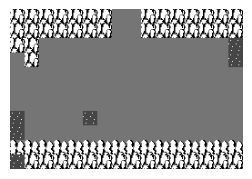

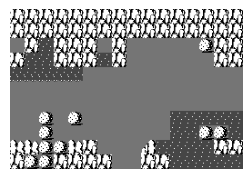

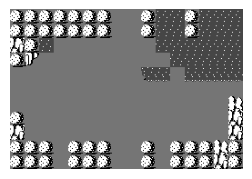

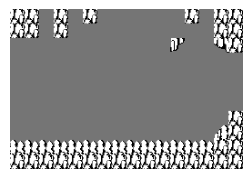

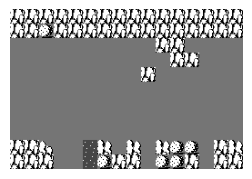

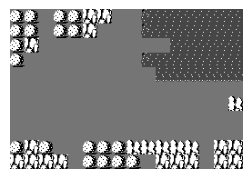

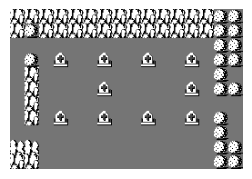

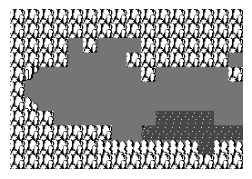

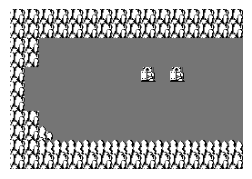

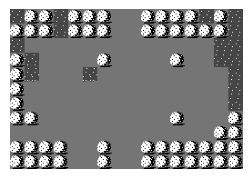

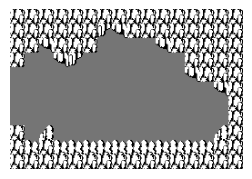

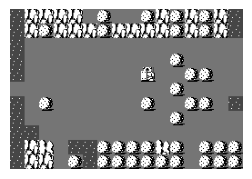

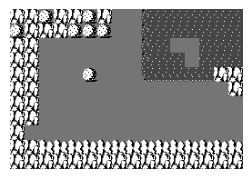

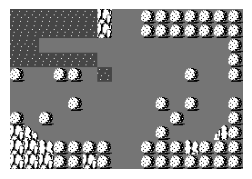

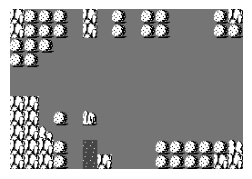

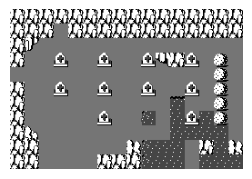

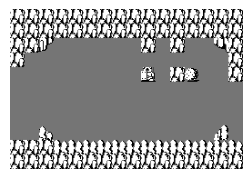

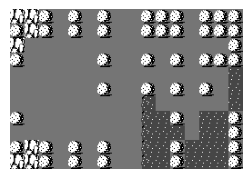

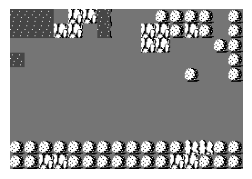

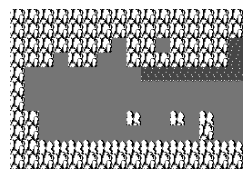

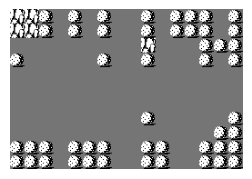

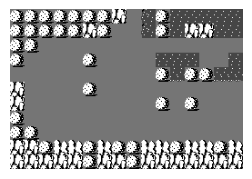

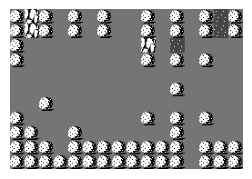

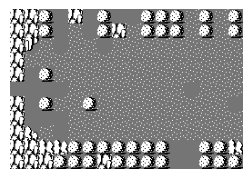

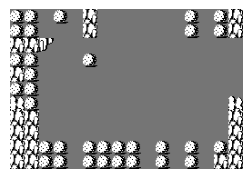

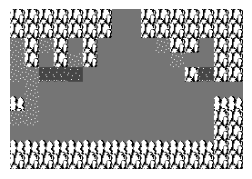

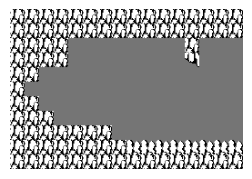

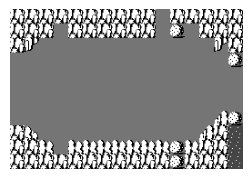

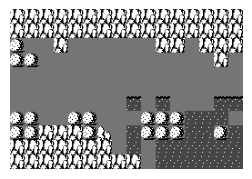

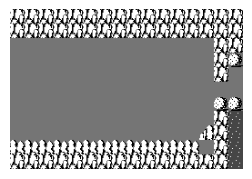

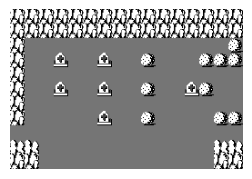

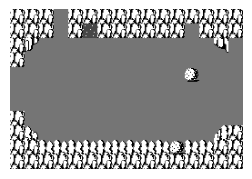

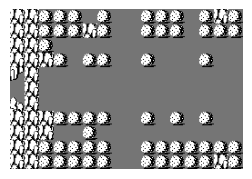

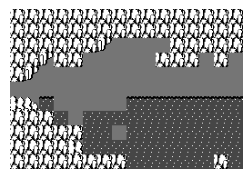

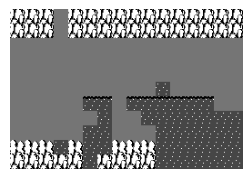

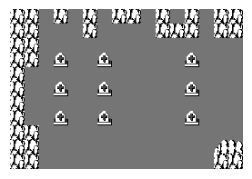

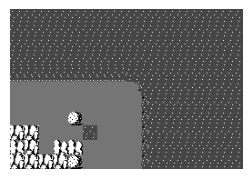

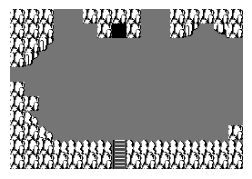

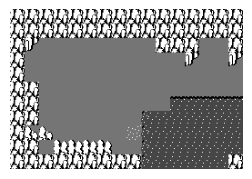

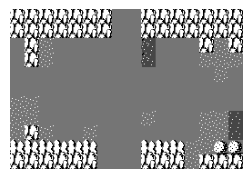

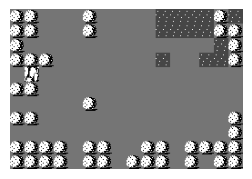

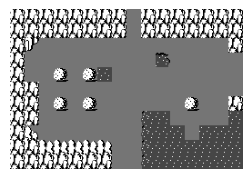

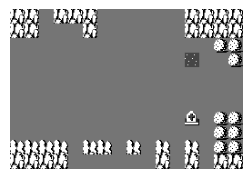

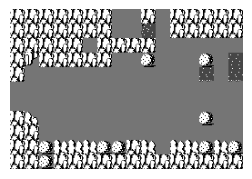

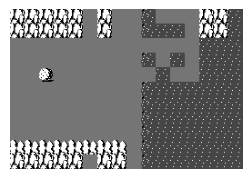

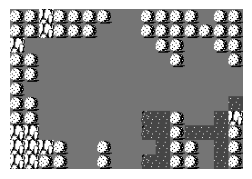

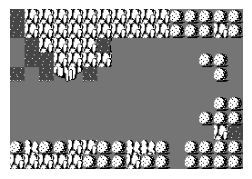

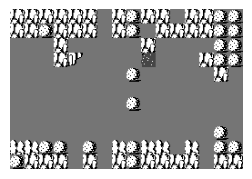

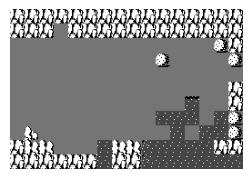

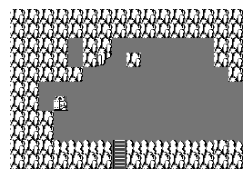

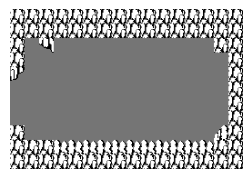

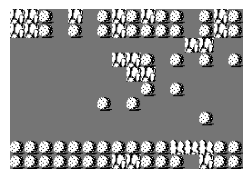

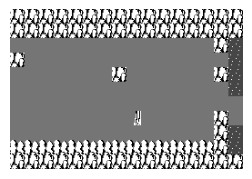

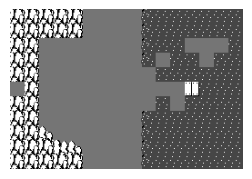

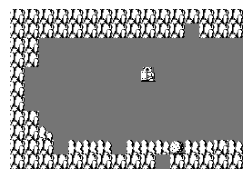

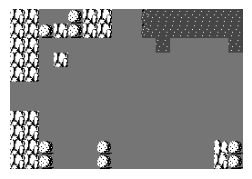

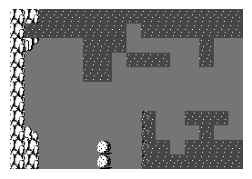

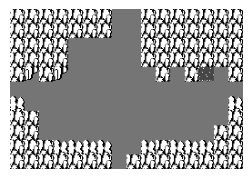

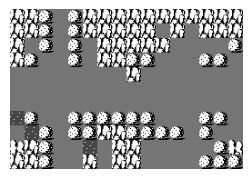

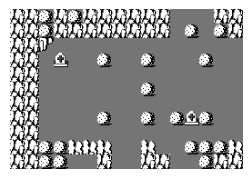

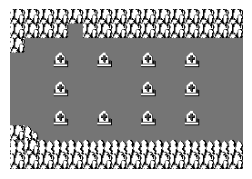

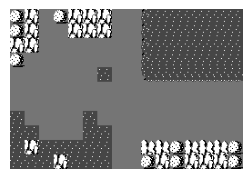

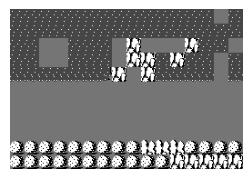

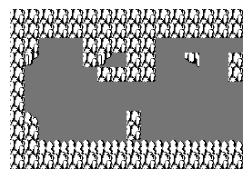

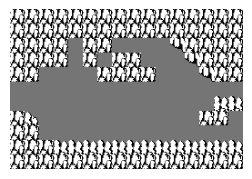

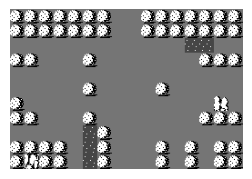

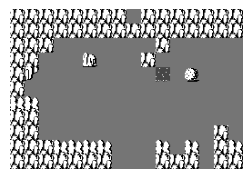

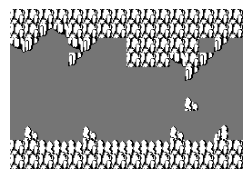

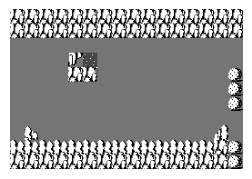

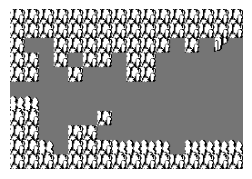

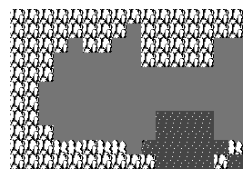

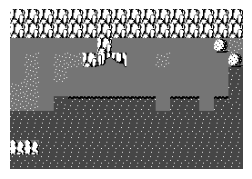

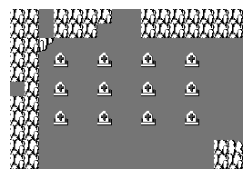

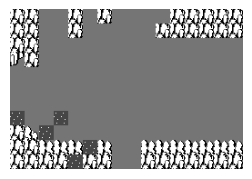

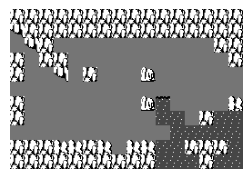

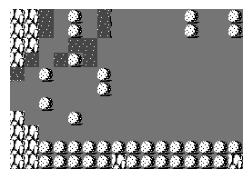

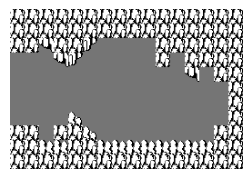

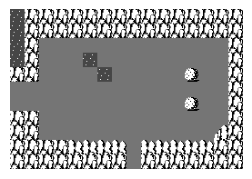

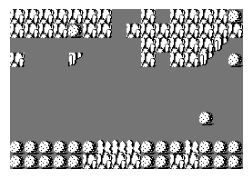

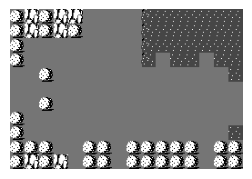

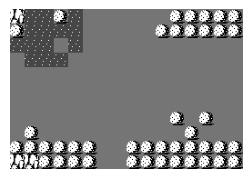

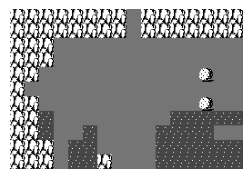

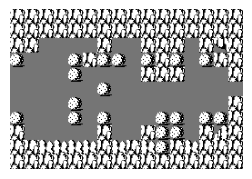

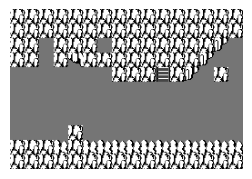

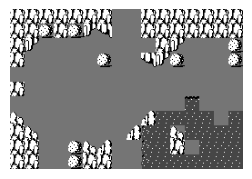

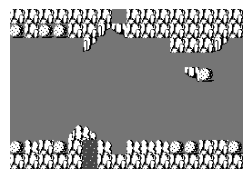

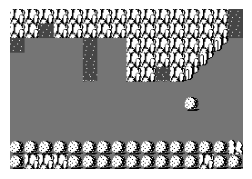

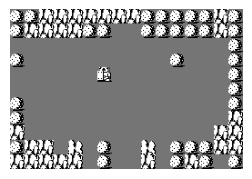

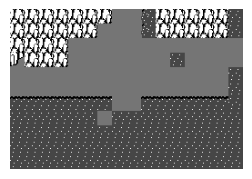

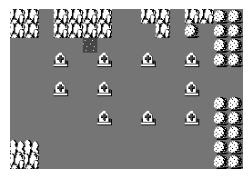

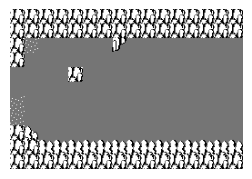

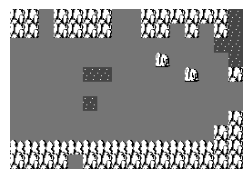

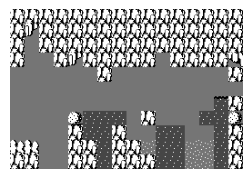

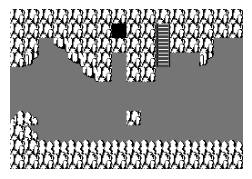

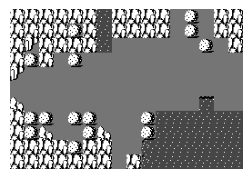

In [35]:
best_vae_model = VAE(input_dim, latent_dim).to(device)
best_vae_model.load_state_dict(torch.load('best_vae_model.pth'))

# Set the VAE model to evaluation mode
best_vae_model.eval()

# Number of samples to generate
num_samples = 127

# Generate random samples from a standard normal distribution
z_samples = torch.randn(num_samples, latent_dim).to(device)

# Decode the samples
with torch.no_grad():
    generated_samples = model.decode(z_samples)

# Convert the generated samples back to numpy arrays
generated_samples = generated_samples.cpu().numpy()
generated_samples_reshaped = generated_samples.reshape(num_samples, 11, 16, 42)

output_dir = "generated_sample"
os.makedirs(output_dir, exist_ok=True)

for idx, sample in enumerate(generated_samples_reshaped):
    plt.figure(figsize=(3, 3))
    image = convert_embedding_to_image(sample, tile_set, tile_size)
    npy_path = os.path.join(output_dir, f'sample_{idx}.npy')
    np.save(npy_path, sample)
    if idx < 10:
        plt.imshow(image.squeeze(), cmap='gray')
        plt.axis('off')
        plt.show()